# Diffusion Probabilistic Model with Cosine Noise Schedule

This notebook implements a **Denoising Diffusion Probabilistic Model (DDPM)** using a cosine noise schedule. The implementation includes data loading, model definition, training, and evaluation.

## 1. Importing Required Libraries
We begin by importing necessary libraries for PyTorch, data handling, and visualization.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from torchvision.utils import save_image, make_grid
from torchvision import transforms, utils

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from tqdm import tqdm

## 2. Data Loading
This section defines the dataset handling using PyTorch's `DataLoader` and transformations.

In [2]:
df_train = pd.read_csv('/pgeoprj/godeep/ej44/gan/MNIST/mnist_train.csv', header=None) # Modify your path here
df_test = pd.read_csv('/pgeoprj/godeep/ej44/gan/MNIST/mnist_test.csv', header=None) # Modify your path here
print(df_train.shape)

y_train = df_train[0].to_numpy()
X_train = df_train.drop(columns = 0)

y_test = df_test[0].to_numpy()
X_test = df_test.drop(columns = 0)

(60000, 785)


In [3]:
X_train = X_train.values.reshape(-1, 1, 28, 28)
X_test = X_test.values.reshape(-1, 1, 28, 28)
print(X_test.shape)

(10000, 1, 28, 28)


In [4]:
X_train = ((X_train/255.) * 2) - 1
X_test = ((X_test/255.) * 2) - 1

In [5]:
train_mean = X_train.mean()/255.
train_std = X_train.std()/255.
print(train_mean, train_std)

-0.0028967805782443732 0.002416531794952656


In [6]:
class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        '''
        Args:
        -----------
            - images(np.ndarray): Array containing all images (X)
            - labels(np.ndarray): Array containing the targets (y)
            - lb(sklearn.preprocessing._label.LabelBinarizer): Label Binarizer to transform labels into one-hot vectors
            - transform(torchvision.transforms.transforms.Compose|None): Variable containing all transformations data has to go through
        Return:
        ---------
            None
        '''
        self.images = images
        self.transform = transform
        self.labels = labels
    
    def __len__(self):
        """
        Args:
        ---------
            None
        Return:
        ---------
            None
        """
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        """
        Args:
        ---------
            - idx (int): Index for selecting a sample from the dataset
        Return:
        ---------
            - img (torch.Tensor): Single image
            - label (torch.Tensor): Label corresponding to img
        """
        
        data = self.images[idx]
        img = data.reshape((28,28)).astype(np.uint8)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        
        return img, label

In [7]:
train_transform = transforms.Compose(
                    [
                    transforms.ToTensor()
                    ])

val_transform = transforms.Compose(
                    [
                    transforms.ToTensor()
                    ])

test_transform = val_transform

In [8]:
dataset = MnistDataset(X_train, y_train, transform=train_transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

test_dataset = MnistDataset(X_test, y_test, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

tensor([9, 0, 6, 4, 5, 7, 7, 2])
tensor([7, 2, 1, 0, 4, 1, 4, 9])


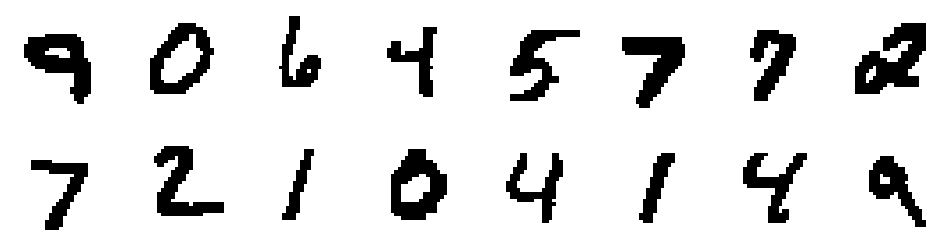

In [9]:
fig, ax = plt.subplots(2,8, figsize=(12, 3))

# Plot training set examples
idx = 0
for data, label in dataloader:
    for j in range(8):
        ax[0,j].imshow(data[j].reshape(28,28), cmap='gray')
        ax[0,j].axis("off")
    print(label[:8])
    break

# Plot test set examples
idx = 0
for data, label in test_dataloader:
    for j in range(8):
        ax[1,j].imshow(data[j].reshape(28,28), cmap='gray')
        ax[1,j].axis("off")
    print(label[:8])
    break

## 3. Model Hyperparameters

We define the hyperparameters to the model.

In [10]:
cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")

dataset = dataloader
img_size = (28, 28, 1) # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

train_batch_size = 128
inference_batch_size = 64
lr = 5e-5
epochs = 200

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

## 4. Sinusoidal Positional Embeddings (`SinusoidalPosEmb`)

The `SinusoidalPosEmb` class implements **sinusoidal positional embeddings**, a technique commonly used in transformer models and diffusion models to provide meaningful representations of continuous values such as timesteps. This function **maps a scalar (e.g., a timestep) to a meaningful vector representation** using periodic functions and these embeddings help the model **capture temporal or positional information** in a continuous space.

In [11]:
class SinusoidalPosEmb(nn.Module):
    
    def __init__(self, dim):
        """
        Args:
            dim (int): The dimensionality of the embedding.
        """
        super().__init__()
        self.dim = dim

    def forward(self, x):
        """
        Computes sinusoidal positional embeddings for the given input.

        Args:
            x (torch.Tensor): A tensor of shape (batch_size,) representing input values (e.g., time steps).

        Returns:
            torch.Tensor: A tensor of shape (batch_size, dim) containing the sinusoidal embeddings.
        """
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


## 5. Convolutional Block (`ConvBlock`)

The `ConvBlock` class extends `nn.Conv2d` to create a customizable **2D convolutional block** with optional **activation functions**, **group normalization**, and **residual connections**. This is a fundamental component used in deep learning models for processing image-like data.

In [12]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (int): Size of the convolutional kernel.
            activation_fn (bool, optional): If True, applies the SiLU (Swish) activation function. Default is None.
            drop_rate (float, optional): Dropout rate (not used in this implementation). Default is 0.
            stride (int, optional): Stride for the convolution. Default is 1.
            padding (str or int, optional): Padding size ('same' for automatic calculation). Default is 'same'.
            dilation (int, optional): Dilation rate for dilated convolutions. Default is 1.
            groups (int, optional): Number of blocked connections from input to output channels. Default is 1.
            bias (bool, optional): If True, includes a learnable bias in the convolution. Default is True.
            gn (bool, optional): If True, applies Group Normalization. Default is False.
            gn_groups (int, optional): Number of groups for Group Normalization. Default is 8.
        """
        
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
    def forward(self, x, time_embedding=None, residual=False):
        """
        Performs a forward pass through the convolutional block.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C_in, H, W).
            time_embedding (torch.Tensor, optional): Optional time step embedding for diffusion models.
            residual (bool, optional): If True, applies a residual connection (commonly used in U-Net diffusion models). Default is False.

        Returns:
            torch.Tensor: Output tensor of shape (N, C_out, H, W).
        """
        
        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        
        return y

## 6. Denoising Model (`Denoiser`)

The `Denoiser` class implements a **denoising neural network** designed for **Denoising Diffusion Probabilistic Models (DDPMs)**. This model estimates the noise present in a perturbed image and helps reconstruct a clean image through iterative refinement. The `Denoiser` is used to estimate the noise in an image at a given timestep and helps reconstruct the original image during the **denoising diffusion process**.

In [13]:
class Denoiser(nn.Module): 

    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):

        """
        Args:
            image_resolution (tuple or list): Image shape (H, W, C).
            hidden_dims (list, optional): Hidden layer dimensions. Default is [256, 256].
            diffusion_time_embedding_dim (int, optional): Time embedding dimension. Default is 256.
            n_times (int, optional): Number of diffusion steps. Default is 1000.
        """
        
        super(Denoiser, self).__init__()
        
        _, _, img_C = image_resolution
        
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim) 
        
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7) 
        
        self.time_project = nn.Sequential( 
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))
        
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)]) 
        
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))                                
                               
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3) 
        
        
    def forward(self, perturbed_x, diffusion_timestep): 
        
        """
        Performs a forward pass through the model.
            Args:
                perturbed_x (torch.Tensor): The noisy input image of shape (N, C, H, W).
                diffusion_timestep (torch.Tensor): The current timestep in the diffusion process.

            Returns:
                torch.Tensor: The estimated noise for denoising.
        """
        
        y = perturbed_x
        
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))
        
        y = self.in_project(y)
        
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True)
            
        y = self.out_project(y) 
            
        return y 

# Model Instantiation
model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims, 
                 diffusion_time_embedding_dim=timestep_embedding_dim, 
                 n_times=n_timesteps).to(DEVICE)

# 7. Diffusion Model (`Diffusion`)

The `Diffusion` class implements the **forward and reverse diffusion processes** in a **Denoising Diffusion Probabilistic Model (DDPM)**. This model applies a sequence of noise perturbations to an image and then learns to reverse this process to generate high-quality samples from pure noise.

In [14]:
class Diffusion(nn.Module):
    """
    Args:
        model (nn.Module): The neural network that estimates noise in the reverse diffusion process.
        image_resolution (list): The image size in the format [height, width, channels].
        n_times (int): Number of diffusion steps.
        use_cosine_schedule (bool): If True, uses a cosine noise schedule; otherwise, uses a linear schedule.
        device (str): Specifies whether to use CUDA ('cuda') or CPU ('cpu').
    """
    
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, use_cosine_schedule=True, device='cuda'):
        super(Diffusion, self).__init__()

        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution
        self.model = model
        self.device = device

        # Define noise schedule (cosine or linear)
        if use_cosine_schedule:
            betas = self.cosine_schedule(n_times).to(device)
        else:
            beta_1, beta_T = 1e-4, 2e-2  
            betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device)  

        # Compute key diffusion parameters
        self.sqrt_betas = torch.sqrt(betas)
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)

    def cosine_schedule(self, timesteps, s=0.008):
        """
        Implements a cosine-based noise schedule, as proposed in IDDPM.

        Args:
            timesteps (int): Total number of diffusion steps.
            s (float): Small offset to prevent extreme values (default: 0.008).

        Returns:
            torch.Tensor: A tensor containing the beta values adjusted by the cosine schedule.
        """
        t = torch.linspace(0, timesteps, timesteps + 1, dtype=torch.float32) / timesteps
        f_t = torch.cos((t + s) / (1 + s) * (math.pi / 2)) ** 2
        alphas_cumprod = f_t / f_t[0]  
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999) 
    
    def extract(self, a, t, x_shape): 
        """
        Extracts a specific value from tensor `a` based on index `t` and reshapes it.

        Reference:
            Adapted from lucidrains' implementation:
            https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py
        """
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))

    def scale_to_minus_one_to_one(self, x): 
        return x * 2 - 1
    
    def reverse_scale_to_zero_to_one(self, x): 
        return (x + 1) * 0.5

    def make_noisy(self, x_zeros, t): 
        """
        Adds noise to an image at a given timestep.

        Args:
            x_zeros (torch.Tensor): The original clean image.
            t (torch.Tensor): The current diffusion timestep.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The noisy image and the noise added.
        """
        epsilon = torch.randn_like(x_zeros).to(self.device)
        
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar
    
        return noisy_sample.detach(), epsilon
    
    def forward(self, x_zeros):
        """
        Forward diffusion process: Adds noise to an image and predicts the noise.

        Args:
            x_zeros (torch.Tensor): The clean input image.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: 
                - The perturbed image.
                - The true noise (epsilon).
                - The predicted noise from the model.
        """
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        
        B, _, _, _ = x_zeros.shape
        
        # (1) Randomly choose a diffusion timestep
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device) 
        
        # (2) Apply noise according to the diffusion schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t) 
        
        # (3) Predict the noise given the perturbed image at timestep t
        pred_epsilon = self.model(perturbed_images, t) 
        
        return perturbed_images, epsilon, pred_epsilon
    
    def denoise_at_t(self, x_t, timestep, t):                                  
        """
        Denoises an image at a given timestep during the sampling process.

        Args:
            x_t (torch.Tensor): The noisy image at timestep t.
            timestep (torch.Tensor): The current timestep.
            t (int): The scalar timestep value.

        Returns:
            torch.Tensor: The estimated image at timestep t-1.
        """
        B, _, _, _ = x_t.shape
        if t > 1: 
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)
        
        # Predict noise (epsilon)
        epsilon_pred = self.model(x_t, timestep)
        
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)
        
        # Compute the denoised image
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1 - alpha) / sqrt_one_minus_alpha_bar * epsilon_pred) + sqrt_beta * z
        
        return x_t_minus_1.clamp(-1., 1)

    def sample(self, N): 
        """
        Generates new images by denoising a random noise tensor.

        Args:
            N (int): The number of images to generate.

        Returns:
            torch.Tensor: The generated images.
        """
        # Start from pure Gaussian noise
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)
        
        # Iteratively denoise from x_T to x_0
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)
        
        # Convert back to [0, 1] range
        x_0 = self.reverse_scale_to_zero_to_one(x_t)
        
        return x_0
    

# Model Initialization
diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps, 
                      use_cosine_schedule=True, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

## 8. Training Setup
This section includes loss functions, optimizers, and training routines for the DDPM model.

In [15]:
print("Start training DDPMs...")
model.train()

loss_history = []  # List to store loss per epoch

for epoch in range(epochs):
    noise_prediction_loss = 0  # Initialize loss accumulator for the epoch
    
    # Iterate over the training batches
    for batch_idx, (x, _) in tqdm(enumerate(dataloader), total=len(dataloader)):
        optimizer.zero_grad()  # Reset gradients

        x = x.to(DEVICE)  # Move batch to the appropriate device
        
        # Apply the diffusion process and compute the loss
        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)
        
        noise_prediction_loss += loss.item()  # Accumulate batch loss
        
        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()
    
    # Compute average loss for the epoch
    avg_loss = noise_prediction_loss / batch_idx
    loss_history.append(avg_loss)

    # Print progress every 10 epochs, also for the first and last epoch
    if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == epochs - 1:
        print(f"\tEpoch {epoch + 1}/{epochs} - Denoising Loss: {avg_loss:.6f}")

print("Finish!!")

Start training DDPMs...


100%|██████████| 235/235 [00:19<00:00, 11.76it/s]


	Epoch 1/200 - Denoising Loss: 0.206220


100%|██████████| 235/235 [00:19<00:00, 11.77it/s]


	Epoch 10/200 - Denoising Loss: 0.030381


100%|██████████| 235/235 [00:19<00:00, 11.77it/s]


	Epoch 20/200 - Denoising Loss: 0.026741


100%|██████████| 235/235 [00:19<00:00, 11.77it/s]


	Epoch 30/200 - Denoising Loss: 0.024537


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 40/200 - Denoising Loss: 0.023389


100%|██████████| 235/235 [00:19<00:00, 11.79it/s]


	Epoch 50/200 - Denoising Loss: 0.022803


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 60/200 - Denoising Loss: 0.022252


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 70/200 - Denoising Loss: 0.021415


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 80/200 - Denoising Loss: 0.021315


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 90/200 - Denoising Loss: 0.020755


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 100/200 - Denoising Loss: 0.020512


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 110/200 - Denoising Loss: 0.020417


100%|██████████| 235/235 [00:19<00:00, 11.79it/s]


	Epoch 120/200 - Denoising Loss: 0.020487


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 130/200 - Denoising Loss: 0.020023


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 140/200 - Denoising Loss: 0.020091


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 150/200 - Denoising Loss: 0.019726


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 160/200 - Denoising Loss: 0.019736


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 170/200 - Denoising Loss: 0.019481


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 180/200 - Denoising Loss: 0.019643


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


	Epoch 190/200 - Denoising Loss: 0.019403


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]

	Epoch 200/200 - Denoising Loss: 0.019352
Finish!!


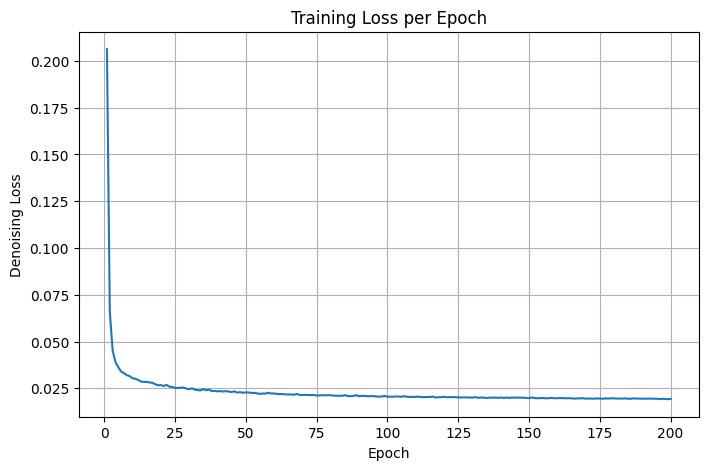

In [16]:
# Plot Loss vs Epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Denoising Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.show()

## 9. Sampling and Evaluation
We generate new samples from the trained model and evaluate its performance.

In [36]:
model.eval()
for batch_idx, (x, _) in enumerate(test_dataloader):
    x = x.to(DEVICE)
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

In [37]:
model.eval()
with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

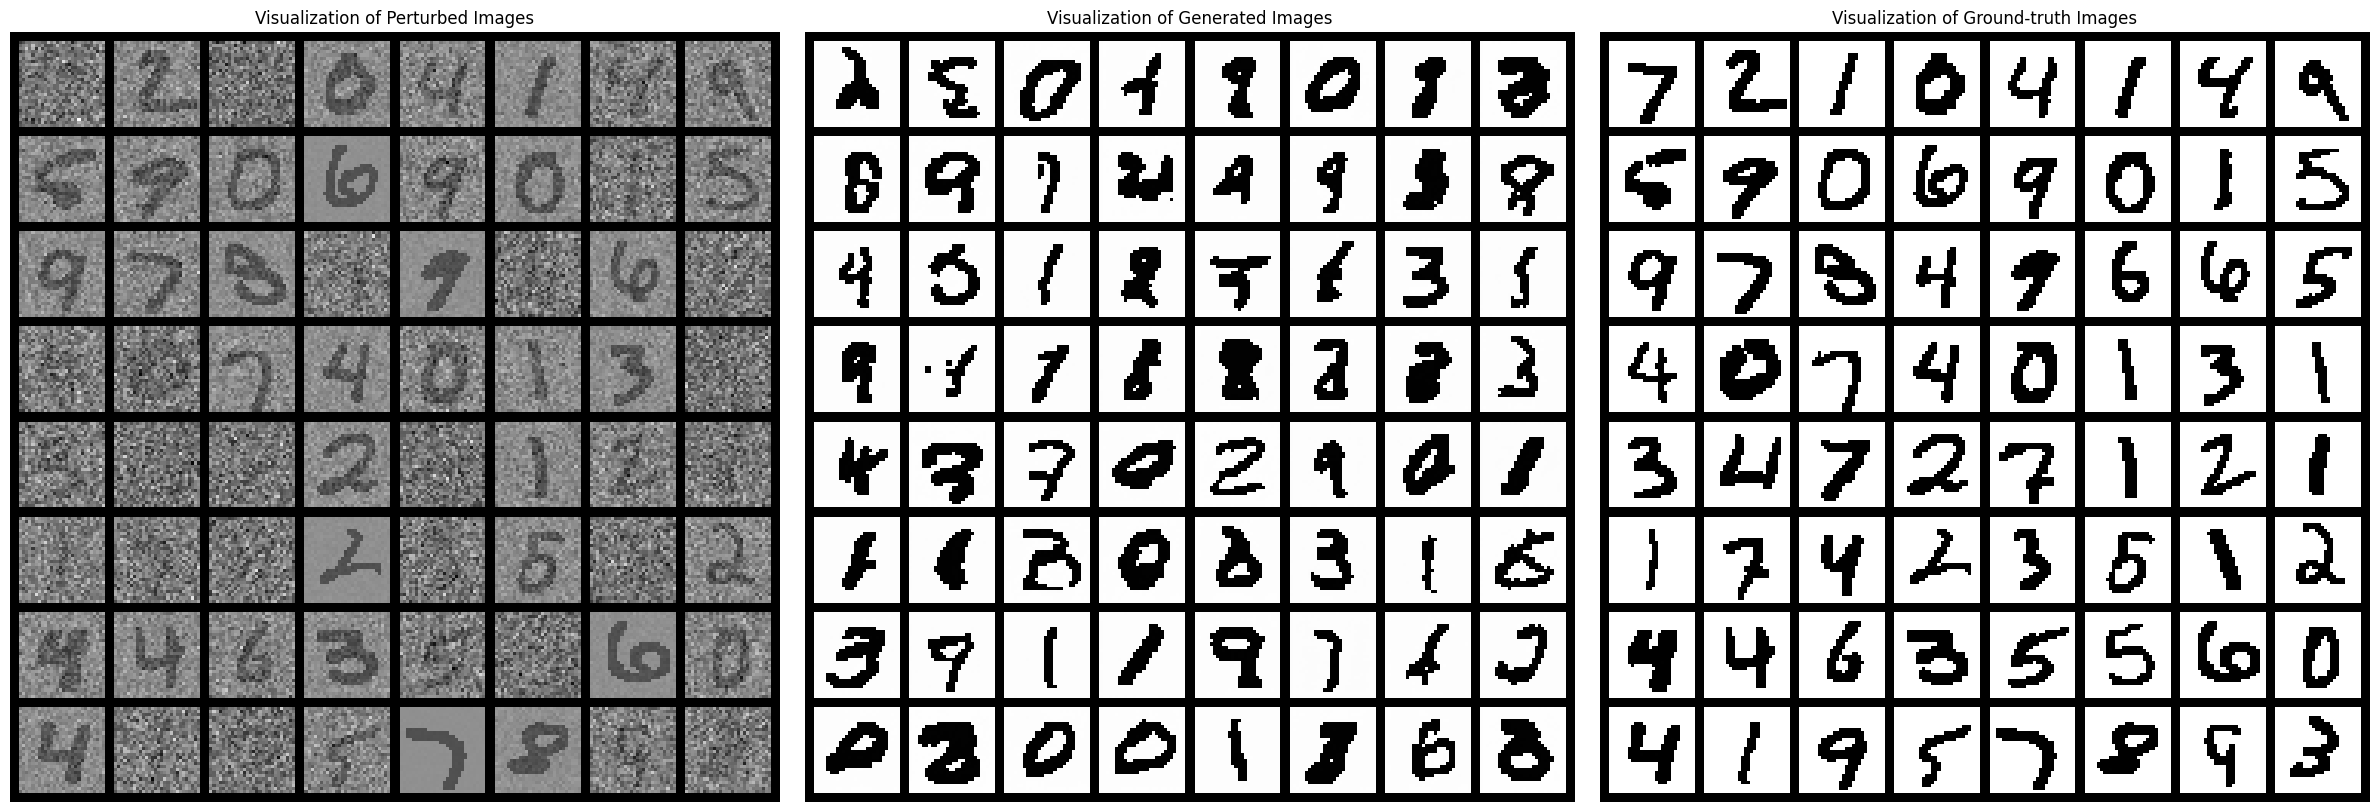

In [38]:
inference_batch_size = 64  

def draw_sample_image(x, postfix, ax):
    ax.axis('off')
    ax.set_title(f"Visualization of {postfix}")
    grid = make_grid(x.detach().cpu(), nrow=8, padding=3, normalize=True)  
    ax.imshow(np.transpose(grid, (1, 2, 0)))

fig, axes = plt.subplots(1, 3, figsize=(24, 8)) 

draw_sample_image(perturbed_images[:inference_batch_size], "Perturbed Images", axes[0])

draw_sample_image(generated_images[:inference_batch_size], "Generated Images", axes[1])

draw_sample_image(x[:inference_batch_size], "Ground-truth Images", axes[2])

plt.tight_layout()
plt.show()